## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [7]:
import glob

import numpy as np
import scipy as sp
import scipy.io


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

### Understanding Dataset

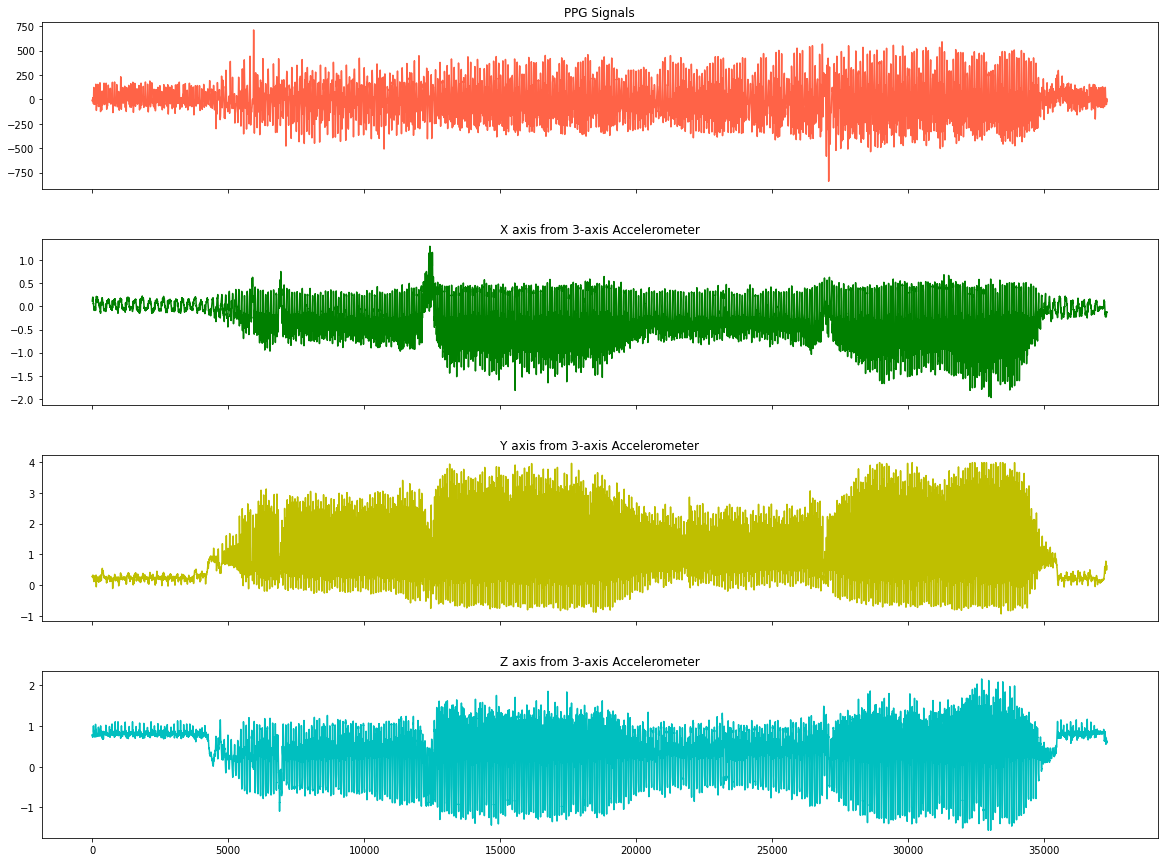

In [105]:
from matplotlib import pyplot as plt

data_fls, ref_fls = LoadTroikaDataset()

file_idx = len(data_fls)-1
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[file_idx])

fig, ax = plt.subplots(nrows=4, figsize=(20,15), sharex=True)
plt.subplots_adjust(hspace=.3)

ax[0].set_title('PPG Signals')
ax[0].plot(ppg, color='tomato')

ax[1].set_title('X axis from 3-axis Accelerometer')
ax[1].plot(accx, color='g')

ax[2].set_title('Y axis from 3-axis Accelerometer')
ax[2].plot(accy, color='y')

ax[3].set_title('Z axis from 3-axis Accelerometer')
ax[3].plot(accz, color='c')

plt.show()

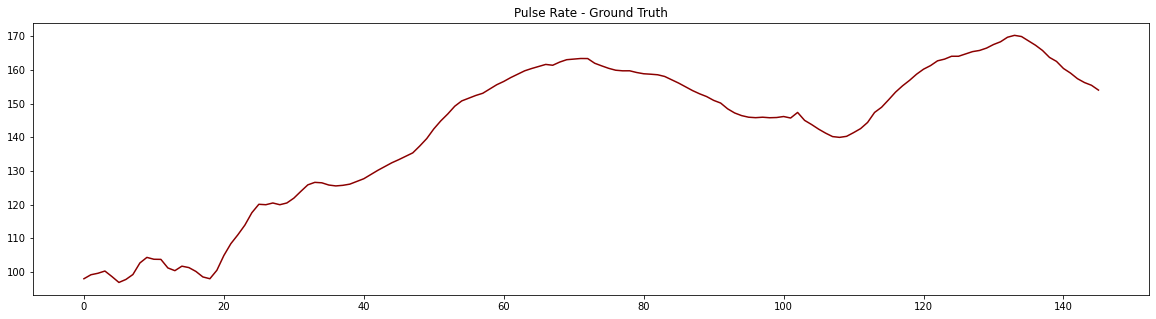

In [106]:
bpm_act = sp.io.loadmat(ref_fls[file_idx])['BPM0']

plt.figure(figsize=(20, 5))
plt.plot(bpm_act, color='darkred')
plt.title('Pulse Rate - Ground Truth')
plt.show()

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(np.array(list(map(len, ppg))) / fs);
plt.xlabel('Time (sec)')
plt.title('Length of ECG records')

TypeError: object of type 'numpy.float64' has no len()

<Figure size 720x432 with 0 Axes>

In [15]:
import scipy.signal as sig

def bandpass_filter(signal, pass_band, fs=125):
    '''
    A bandpass filter will remove all frequency components outside of a given passband.
    
    args:
    signal = Numpy Array for the signal
    pass_band = Tuple with the low and high frequency
    fs = float, The sampling frequency
    
    return:
    Numpy Array, The filtered output with the same shape as signal.
    '''
    # Design an 5th-order Butterworth filter and return the filter coefficients.
    b, a = sig.butter(5, pass_band, btype='bandpass', fs=fs)
    
    # Applies filter and returns the new signal
    return sig.filtfilt(b, a, signal)

In [19]:
def estimate_pulse_rate(ppg, accx, accy, accz):
    '''
    Computes the pulse rate based on PPG values and the Accelerometer data
    
    args:
    ppg  = Numpy Array, Optically obtained plethysmogram signals
    accx = Numpy Array, X-axis signals from a 3-axis accelerometer
    accy = Numpy Array, Y-axis signals from a 3-axis accelerometer
    accz = Numpy Array, Z-axis signals from a 3-axis accelerometer
    
    returns:
    bpm_est = Estimated pulse rate
    confidence = 
    '''
    pass

In [ ]:
freqs = np.fft.rfftfreq(len(s), 1/fs)
fft = np.fft.rfft(s)

In [20]:
def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    # Apply a bandpass filter to signals
    pass_band = (40/60, 240/60) # pulse rate is restricted between 40BPM and 240BPM
    ppg_f  = bandpass_filter(ppg,  pass_band)
    accx_f = bandpass_filter(accx, pass_band)
    accy_f = bandpass_filter(accy, pass_band)
    accz_f = bandpass_filter(accz, pass_band)

    # Compute pulse rate estimates and estimation confidence.
    bpm_est, confidence = estimate_pulse_rate(ppg_f, accx_f, accy_f, accz_f)

    # Calculate error rate by comparing to actual (Ground Truth) values
    bpm_act = sp.io.loadmat(ref_fl)['BPM0']
    errors  = np.diag(np.subtract(bpm_est, bpm_act))
    
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    return errors, confidence

In [21]:
Evaluate()

TypeError: cannot unpack non-iterable NoneType object

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 